# Evaluate models

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import scipy.stats
from sklearn.metrics import mean_squared_error


plt.style.use('dark_background')

### Task definition
Specify which task to evaluate: feature selection has been done for `detection_per_mol` and `regression_on_detected` only.

In [2]:
# TASK_NAME = "detection_per_ion"
# TASK_NAME = "detection_per_mol_max"
# TASK_NAME = "regression_on_detected"
TASK_NAME = "rank_matrices"
# TASK_NAME = "pytorch_nn_detection"
# TASK_NAME = "regression_on_detected_per_mol_max"
# TASK_NAME = "regression_on_detected_per_mol_sum"


EVAL_FEAT_SEL = False

### Define input files and score functions

In [3]:
# assert TASK_NAME in ["detection_per_mol",
#                      "detection_per_ion",
#                      "regression_on_detected",
#                      "rank_matrices",
#                      "pytorch_nn_detection"]

# if EVAL_FEAT_SEL:
#     assert TASK_NAME in ["detection_per_mol",
#                      "regression_on_detected"]

plots_dir = Path.cwd() / "../plots" / TASK_NAME
plots_dir.mkdir(exist_ok=True, parents=True)
results_dir = Path.cwd() / "../results" / TASK_NAME
raw_intensities_csv = Path.cwd() / "../input_data/intensity_data_raw.csv"



In [4]:
def get_scores(data, task_type="classification"):
    """
    FIXME: generalize for multiple classes
    :param data:
    :param task_type:
    :return:
    """
    if task_type == "classification":
        clf_report = classification_report(data.observed_value, data.prediction, output_dict=True, zero_division=0)
        scores = [clf_report['0']['precision'], clf_report['0']['recall'],
                  clf_report['0']['f1-score'], clf_report['0']['support'],
                  clf_report['1']['precision'], clf_report['1']['recall'],
                  clf_report['1']['f1-score'], clf_report['1']['support'],
                  clf_report['macro avg']['f1-score']]
        if data.observed_value.max() == 0:
            print("no detection!")
    elif task_type == "regression":
        spearman = scipy.stats.spearmanr(data.observed_value, data.prediction)
        pearson = scipy.stats.pearsonr(data.observed_value, data.prediction)
        mse = mean_squared_error(data.observed_value, data.prediction, squared=False)
        mse_std = mse / data['observed_value'].std()
        scores = [spearman[0], spearman[1],
                  pearson[0], pearson[1], mse, mse_std,
                  data[data['observed_value'] != 0].shape[0]]
    else:
        raise ValueError(task_type)
    return scores

Functions to compute scores:

In [5]:
def get_molecules_with_zero_formal_charge():
    raw_intensities_df = pd.read_csv(raw_intensities_csv, index_col=0)
    return raw_intensities_df[raw_intensities_df.formal_charge == 0.0]["name_short"].drop_duplicates().to_list()

molecules_with_zero_charge = get_molecules_with_zero_formal_charge()

In [6]:
def compute_scores(filenames, task_name, task_type,
                   eval_feat_selection=False,
                   test_all_adduct_setups=False,
                   load_multiple_thresholds=False,
                   thresh_column_name=None):
    assert not (eval_feat_selection and load_multiple_thresholds)
    if load_multiple_thresholds:
        assert thresh_column_name is not None
    main_col_names = ['train_setup', 'model_type', 'adduct_setup']
    if eval_feat_selection: main_col_names += ['feat_sel_method', 'quantile', 'nb_features']
    if load_multiple_thresholds: main_col_names += [thresh_column_name]

    adduct_setups_settings = {
        "All adducts": {
            "adducts": ['-H', '+Cl', '[M]-', '+H', '[M]+', '+K', '+Na'],
            "only_zero_formal_charge": False
        }}
    if test_all_adduct_setups:
        extra_setups = {
            "Only '-H'/'+H' adducts and metabolites with zero formal charge": {
                "adducts": ['-H', '+H'],
                "only_zero_formal_charge": True
            },
            "No radicals adducts '[M]+'/'[M]-' and only metabolites with zero formal charge": {
                "adducts": ['-H', '+Cl', '+H', '+K', '+Na'],
                "only_zero_formal_charge": True
            }
        }
        adduct_setups_settings.update(extra_setups)

    all_model_typenames = np.array([
        "classifier",
        "regressor",
        "model_type"
    ])

    if "detection" in task_name:
        score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                      'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']
    elif "regression" in task_name or "rank" in task_name:
        score_cols = ["Spearman's R", 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs']
    else:
        raise ValueError(task_name)

    # Define result dataframes:
    model_metrics = pd.DataFrame(columns=['matrix', 'polarity'] + main_col_names + score_cols)
    model_metrics_global = pd.DataFrame(columns=main_col_names + score_cols)
    models_predictions = pd.DataFrame()
    counter = 0
    counter_global = 0

    # Loop over training configs:
    model_typename = None
    for train_setup in filenames:
        result_filename = filenames[train_setup]
        loc_models_results = pd.read_csv(results_dir / result_filename, index_col=0)
        loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                                'Polarity': 'polarity'})

        # Deduce model_typename:
        model_typename = all_model_typenames[np.isin(all_model_typenames, loc_models_results.columns.to_numpy())].item()

        if loc_models_results.prediction.isna().sum() != 0:
            print("NAN VALUES!! {}/{}".format(loc_models_results.prediction.isna().sum(),
                                              loc_models_results.prediction.shape[0]))
            loc_models_results.loc[loc_models_results.prediction.isna(), "prediction"] = 0

        if loc_models_results.observed_value.dtype == "bool":
            loc_models_results.observed_value = np.where(loc_models_results.observed_value, 1, 0)
        if loc_models_results.prediction.dtype == "bool":
            loc_models_results.prediction = np.where(loc_models_results.prediction, 1, 0)
        if task_name == "pytorch_nn_detection" or ("detection" in task_name):
            # Binarize predictions:
            loc_models_results.prediction = np.where(loc_models_results.prediction > 0.5, 1, 0)

        if "regression" in task_name:
            # Remove undetected from regression score:
            loc_models_results = loc_models_results[loc_models_results['observed_value'] != 0]
        elif "rank" in task_name:
            # Remove nan and not-detected from score computation:
            loc_models_results = loc_models_results[loc_models_results['observed_value'] > 0]

        loc_models_results["train_setup"] = train_setup
        models_predictions = pd.concat([models_predictions, loc_models_results])

        # Loop over adduct setups:
        for adduct_setup in adduct_setups_settings:
            # print(adduct_setup)
            # Filter results according to the adduct setup:
            used_adducts = adduct_setups_settings[adduct_setup]["adducts"]
            # print(f"Kept {np.isin(loc_models_results.adduct, used_adducts).sum()} rows out of {loc_models_results.shape}")

            if "adduct" in loc_models_results.columns.to_list():
                loc_models_results_adduct_setup = loc_models_results[np.isin(loc_models_results.adduct, used_adducts)]
            else:
                loc_models_results_adduct_setup = loc_models_results.copy()
            if adduct_setups_settings[adduct_setup]["only_zero_formal_charge"]:
                # print("Removing formal charge...")
                loc_models_results_adduct_setup = loc_models_results[np.isin(loc_models_results.name_short, molecules_with_zero_charge)]

            # Loop over matrices and model types:
            groupby_cols = ['matrix', 'polarity', model_typename]
            if eval_feat_selection: groupby_cols += ['feat_sel_method', 'feat_sel_quantile']
            if load_multiple_thresholds: groupby_cols += [thresh_column_name]
            for groupby_items, rows in loc_models_results_adduct_setup.groupby(groupby_cols):
                # Compute scores:
                matrix, polarity, model_type = groupby_items[:3]
                scores = get_scores(rows, task_type=task_type)

                # Prepare new row of database with scores:
                new_result_row = [matrix, polarity, train_setup, model_type, adduct_setup]
                if eval_feat_selection:
                    feat_sel_met, quantile = groupby_items[3:]
                    new_result_row += [feat_sel_met, round(quantile * 6), rows["nb_features"].drop_duplicates()[0]]
                elif load_multiple_thresholds:
                    thresh_val = groupby_items[3]
                    new_result_row += [thresh_val]

                model_metrics.loc[counter] = new_result_row + scores
                counter += 1


            # Compute global scores:
            # Loop over model types:
            groupby_cols = [model_typename]
            if eval_feat_selection: groupby_cols += ['feat_sel_method', 'feat_sel_quantile']
            if load_multiple_thresholds: groupby_cols += [thresh_column_name]
            for groupby_items, rows in loc_models_results_adduct_setup.groupby(groupby_cols):

                # Compute global scores:
                model_type = groupby_items[0] if (eval_feat_selection or load_multiple_thresholds) else groupby_items
                scores = get_scores(rows, task_type=task_type)

                # Prepare new row of database with scores:
                new_result_row = [train_setup, model_type, adduct_setup]
                if eval_feat_selection:
                    feat_sel_met, quantile = groupby_items[1:]
                    new_result_row += [feat_sel_met,  round(quantile * 6), rows["nb_features"].drop_duplicates()[0]]
                elif load_multiple_thresholds:
                   thresh_val = groupby_items[1]
                   new_result_row += [thresh_val]

                model_metrics_global.loc[counter_global] = new_result_row + scores
                counter_global += 1

    if not test_all_adduct_setups:
        # TODO: remove extra duplicates
        pass

    return model_metrics, model_metrics_global, models_predictions, model_typename


### Load predictions and compute scores


In [14]:
# TODO: refactor this

if EVAL_FEAT_SEL:
    filenames = {
        # "Fingerprints features": "fingerprints_feat_selection_results.csv",
        "All features": "all_feat_selection_results.csv"
    }
else:
    # filenames = {
    #     "Fingerprints+Mol features": "results_all_feat.csv",
    #     "Fingerprings features": "results_fingerprints_feat.csv",
    #     "Mol features": "results_mol_feat.csv",
    #     "Baseline (only adduct info)": "results_random_feat.csv",
    # }


    # Compare PyTorch models:
    filenames = {
        "Lambda": "lambdaLoss/results_all_feat.csv",
        "neuralNDCG loss": "test_skorch/results_all_feat.csv",
        "rankNet loss": "rankNet/results_all_feat.csv",
        # "Pytorch fixed features": "pytorch_model_fixed_features/results_all_feat.csv",
        # "Pytorch Dice": "pytorch_model_diceloss/results_all_feat.csv",
        # "Pytorch Dice 200": "pytorch_model_diceloss/results_all_feat_200epochs.csv",
        # "Fingerprings features": "results_fingerprints_feat.csv",
        # "Mol features": "results_mol_feat.csv",
        "Baseline (only adduct info)": "results_random_feat.csv",
    }
    # # Compare PyTorch models:
    # filenames = {
    #     "Fingerprints+Mol features": "results_all_feat.csv",
    #     "Pytorch 200": "pytorch_model/results_all_feat_200epochs.csv",
    #     "Pytorch fixed features": "pytorch_model_fixed_features/results_all_feat.csv",
    #     # "Pytorch Dice": "pytorch_model_diceloss/results_all_feat.csv",
    #     "Pytorch Dice 200": "pytorch_model_diceloss/results_all_feat_200epochs.csv",
    #     # "Fingerprings features": "results_fingerprints_feat.csv",
    #     # "Mol features": "results_mol_feat.csv",
    #     "Baseline (only adduct info)": "results_random_feat.csv",
    # }


    # filenames = {
    #     "pred_val>0.95": "detection_per_mol_max_thresh_005/results_all_feat.csv",
    #     "pred_val>0.8": "results_all_feat.csv",
    #     # "Baseline>2": "detection_per_mol_max_intensity_greater_2/results_random_feat.csv",
    #     "norm_intensity>2": "detection_per_mol_max_intensity_greater_2/results_all_feat.csv",
    #     # "Thresh 0.7": "detection_per_mol_max_thresh_03/results_all_feat.csv",
    #     "pred_val>0.95 and norm_intensity>2": "detection_per_mol_max_thresh_005_2/results_all_feat.csv",
    #     # "pred_val>0.95 and norm_intensity>2 mol": "detection_per_mol_max_thresh_005_2/results_mol_feat.csv",
    #     "Baseline (only adduct info)": "detection_per_mol_max_thresh_005_2/results_random_feat.csv",
    #     # "Baseline (only adduct info)": "results_random_feat.csv",
    # }


    # Rename baseline in case we do not give adduct information:
    if "per_mol" in TASK_NAME:
        filenames["Baseline (no input features)"] =  filenames.pop("Baseline (only adduct info)")



In [15]:
if "detection" in TASK_NAME:
    metric = "macro_avg_f1_score"
    count_key = 'detected'
    task_typename = "classification"
elif "regression" in TASK_NAME or "rank" in TASK_NAME:
    metric = "Spearman's R"
    count_key = 'non-zero obs'
    task_typename = "regression"
else:
    raise ValueError(TASK_NAME)



In [16]:
# Compute the actual scores:
model_metrics, model_metrics_global, models_predictions, model_typename = \
    compute_scores(filenames, TASK_NAME, task_typename, EVAL_FEAT_SEL)

## Plot scores

TODO CHANGE: If `EVAL_FEAT_SEL==True`, nothing will be plotted in this section

### Results for all matrices and model types

Plot results for task rank_matrices:


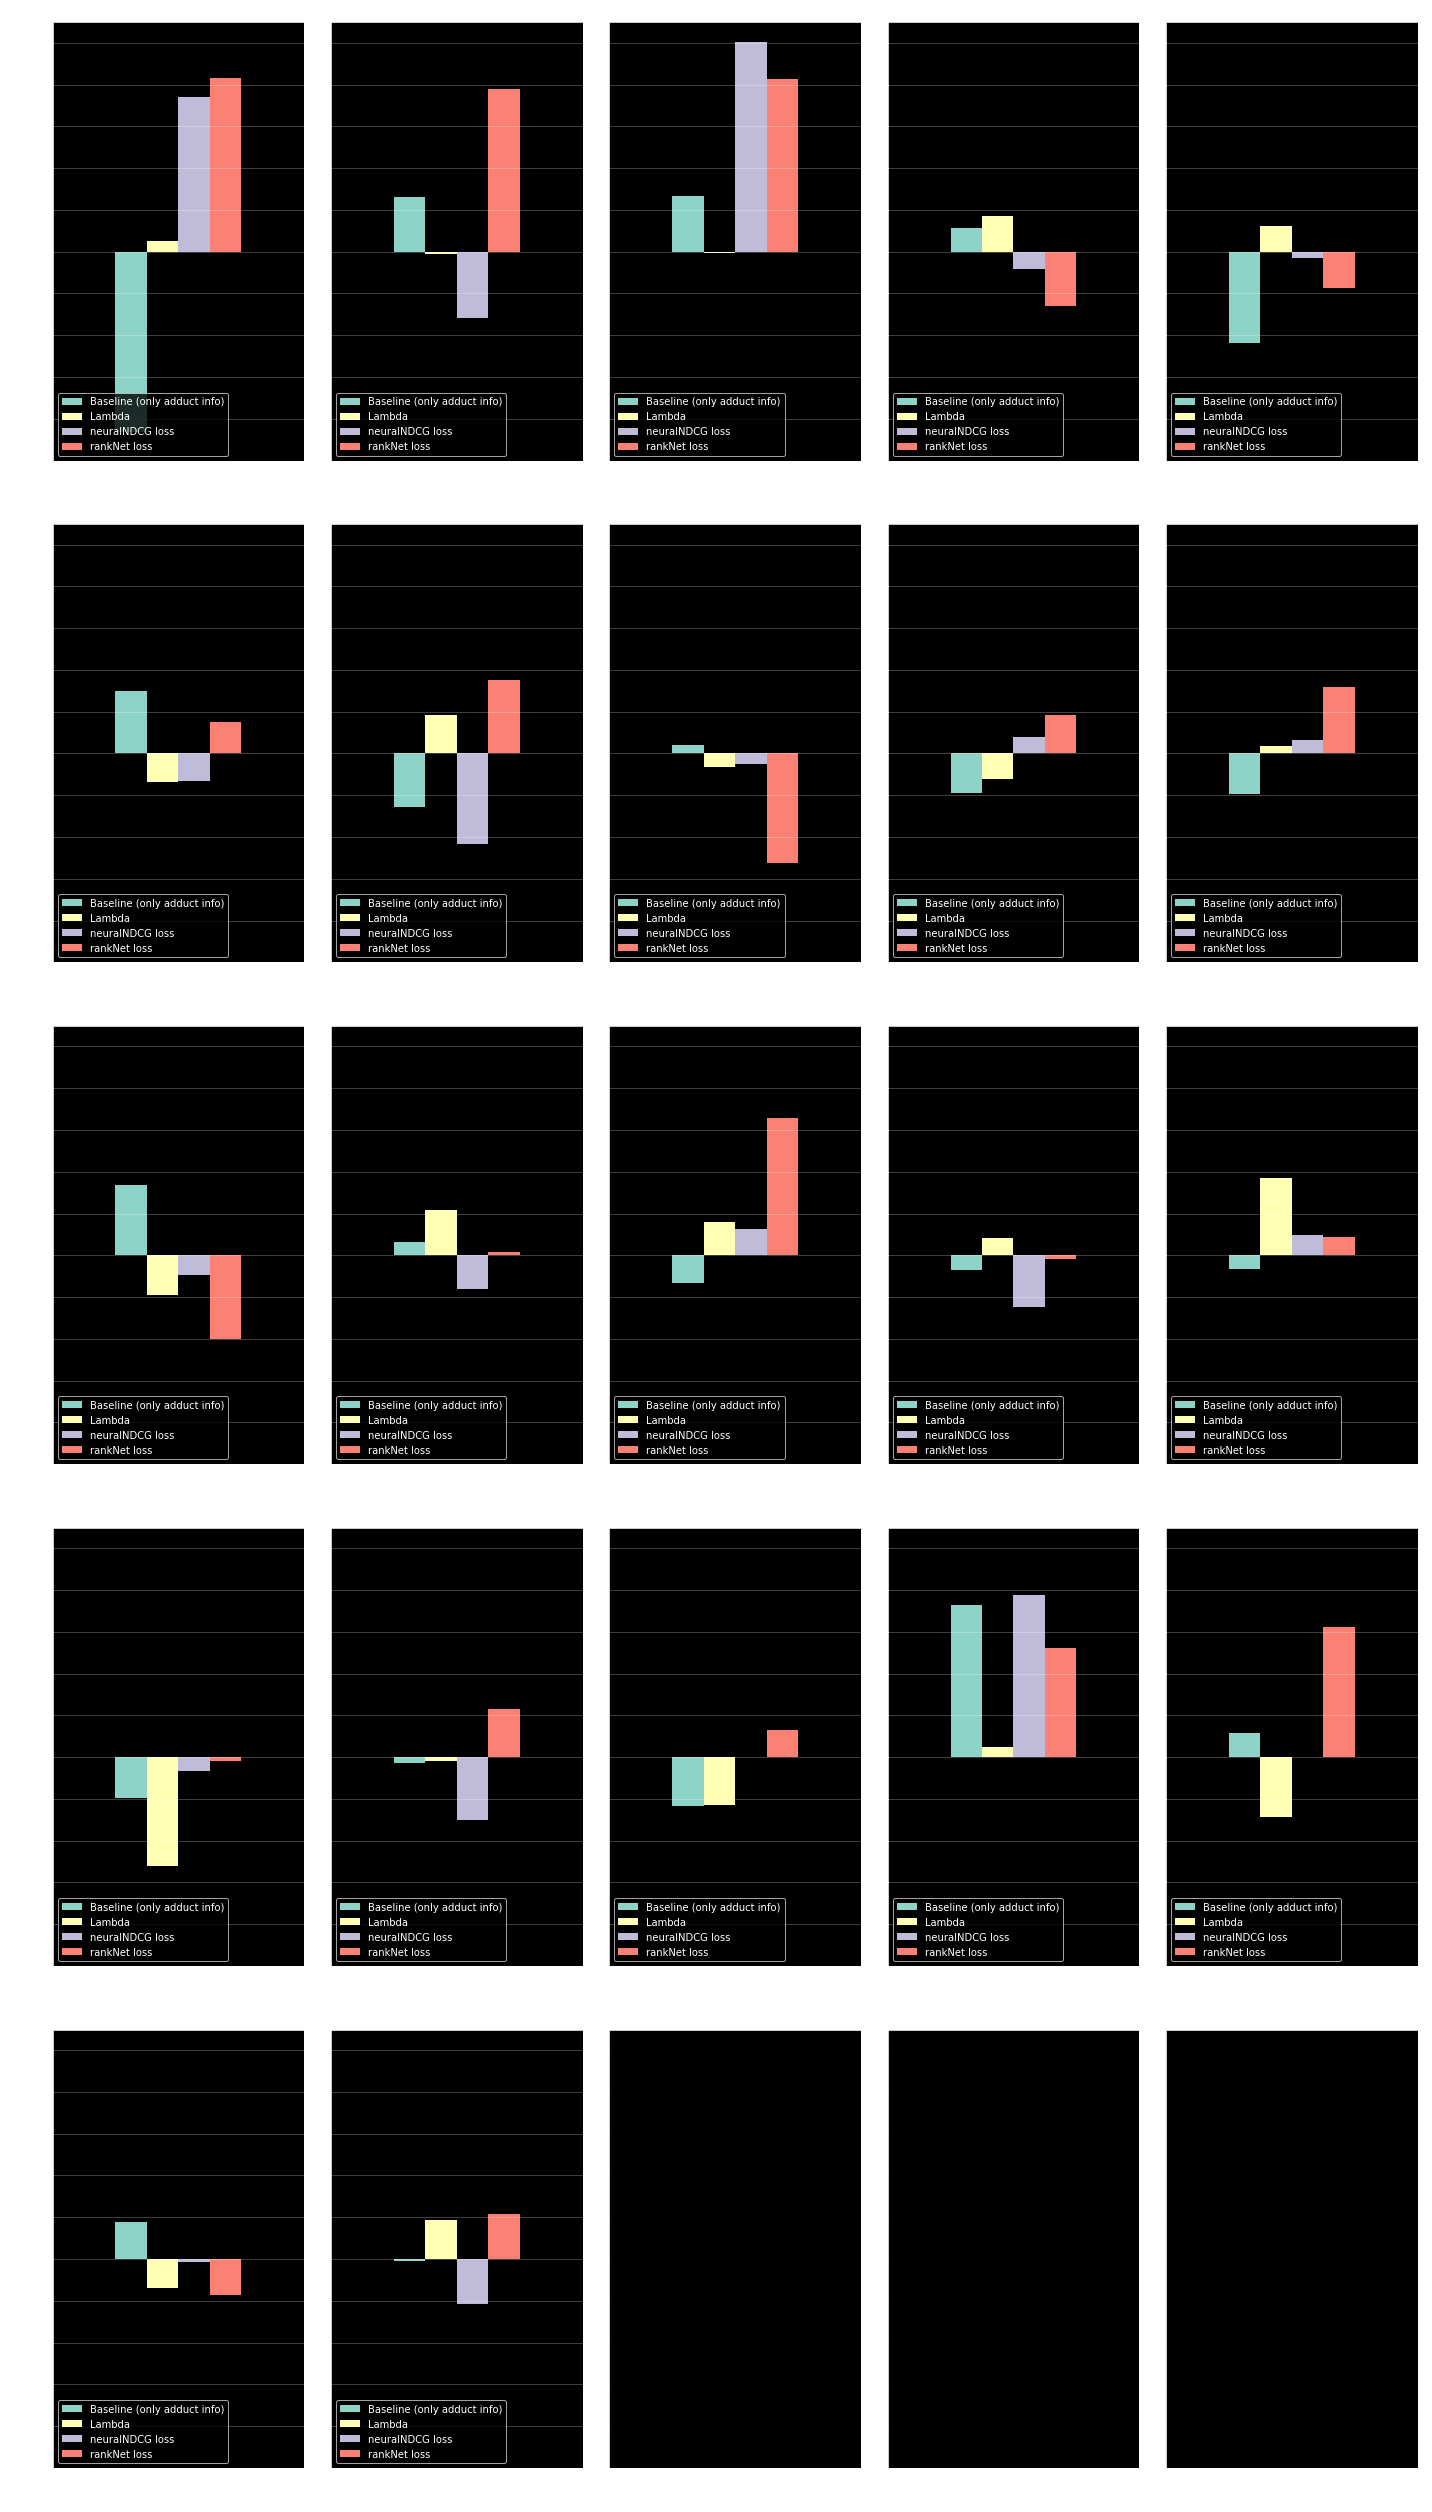

In [17]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
    ax_list = axes.flat

    i = 0
    for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
        nb_obs = rows[count_key].drop_duplicates().values[0]
        rows = rows.set_index(['model_type', "train_setup"], drop = True).sort_values( by = ["train_setup", metric])
        rows = rows.unstack("train_setup")
        rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
        ax_list[i].set_ylabel(metric)
        ax_list[i].legend(loc="lower left")
        ylims = [0.1*round(lim/0.1) for lim in ax_list[i].get_ylim()]
        ax_list[i].set_yticks(np.arange(ylims[0], ylims[1]+0.1, 0.1))
        ax_list[i].grid(visible=True, alpha=0.3, axis='y')

        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    # plt.subplots_adjust(hspace=0.5)
    # fig.suptitle(f"TASK NAME: {TASK_NAME}")
    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"scores_all_matrices.pdf")



Global scores across model types:

Plot results for task rank_matrices:


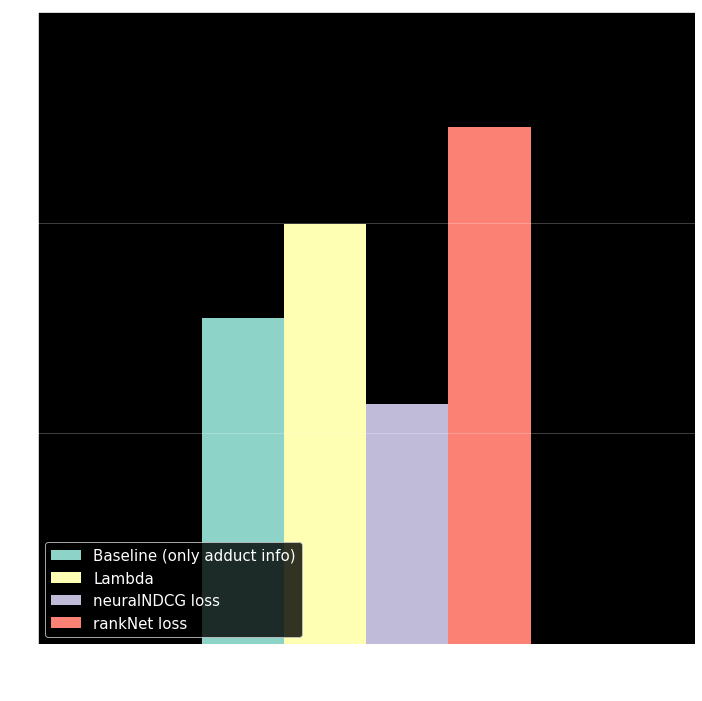

In [18]:
if not EVAL_FEAT_SEL:
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 10))
    print(f"Plot results for task {TASK_NAME}:")
    model_metrics_global.set_index(["model_type", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(ax=ax)
    ax.legend(loc="lower left")
    ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    ax.set_yticks(np.arange(ylims[0], ylims[1]+0.1, 0.1))
    ax.grid(visible=True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"scores_global.pdf")


### Show scores for a specific model type

In [ ]:
if "rank" in TASK_NAME or (TASK_NAME == "pytorch_nn_detection"):
    selected_model = "NN"
else:
    selected_model = "MLP"

In [ ]:
if not EVAL_FEAT_SEL:
    plotted_model_metrics = model_metrics[model_metrics.model_type == selected_model]
    plotted_model_metrics_global = model_metrics_global[model_metrics_global.model_type == selected_model]

    plotted_model_metrics_global.loc[:,"matrix"] = "GLOBAL"
    plotted_model_metrics_global.loc[:,"polarity"] = "all matrices"

    plotted_model_metrics = pd.concat([plotted_model_metrics, plotted_model_metrics_global],
                                      ignore_index=True)


In [ ]:
# filtered = plotted_model_metrics[plotted_model_metrics.train_setup == "pred_val>0.95"]
# filtered
# filtered.detected + filtered.not_detected
plotted_model_metrics["total_points"] = plotted_model_metrics["detected"] + plotted_model_metrics["not_detected"]

In [ ]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (10, 10))
    plt.rcParams.update({'font.size': 16})
    plotted_model_metrics["Matrix (polarity)"] = plotted_model_metrics["matrix"] + " (" + plotted_model_metrics["polarity"] + ")"


    plotted_model_metrics.set_index(["Matrix (polarity)", "train_setup"], drop=True)["total_points"].unstack("train_setup").plot.bar(ax=ax)
    # ax.legend(loc="lower left")
    ax.set_ylabel("total_points")
    ax.set_ylim([0, 200])
    # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # fig.savefig(plots_dir / f"{selected_model}_scores.pdf")

In [ ]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (10, 10))
    plt.rcParams.update({'font.size': 16})
    plotted_model_metrics["Matrix (polarity)"] = plotted_model_metrics["matrix"] + " (" + plotted_model_metrics["polarity"] + ")"


    plotted_model_metrics.set_index(["Matrix (polarity)", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(ax=ax)
    ax.legend(loc="lower left")
    ax.set_ylabel(metric)
    ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3)
    plt.tight_layout()
    fig.savefig(plots_dir / f"{selected_model}_scores.pdf")

In [ ]:
# models_predictions[models_predictions.train_setup == "Baseline 2"]
models_predictions[models_predictions.train_setup == "Thresh 0.95 and intensity > 2"]

#### Plot scatter plots in case of regression

Select the training setup on which to focus on:

In [190]:
selected_train_setup = "Fingerprints+Mol features"
# selected_train_setup = "Fingerprings features"
# selected_train_setup = "Mol features"
# selected_train_setup = "Baseline (only adduct info)"



In [191]:
if not EVAL_FEAT_SEL and task_typename == "regression" :
    print(f"Plot results for task {TASK_NAME}:")
    fig, axes = plt.subplots(ncols=5,nrows=5, figsize= (25, 30))
    ax_list = axes.flat



    i = 0
    for (matrix, polarity), rows in models_predictions.groupby(['matrix', 'polarity']):
        rows = rows[rows["train_setup"] == selected_train_setup]
        rows = rows[rows["observed_value"] > 0]
        rows[rows[model_typename] == selected_model].plot.scatter(x = 'observed_value', y= 'prediction',
                                                       ax = ax_list[i], title=f"{matrix}-{polarity}")
        i+=1

    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"{selected_model}_{selected_train_setup}_scatter_plot.pdf")



Only plot for DHB positive:

In [192]:
if not EVAL_FEAT_SEL and task_typename == "regression":
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 22})

    fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 10))
    # ax_list = axes.flat

    i = 0
    rows = models_predictions[(models_predictions.matrix == "DHB") & (models_predictions.polarity == "positive") & (models_predictions.train_setup == selected_train_setup)]
    rows = rows[rows["observed_value"] > 0]
    rows[rows[model_typename] == selected_model].plot.scatter(x = 'observed_value', y= 'prediction',
                                                       ax = ax, title="DHB-positive")

    # plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"{selected_model}_{selected_train_setup}_scatter_plot_DHB-positive.png")


### Plots for different adduct info


In [193]:
if not EVAL_FEAT_SEL:
    model_metrics, model_metrics_global, models_predictions, model_typename = \
        compute_scores(filenames, TASK_NAME, task_typename, EVAL_FEAT_SEL,
                   test_all_adduct_setups=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alberto-mac/EMBL_repos/spotting-project-regression/notebooks/../results/detection_per_mol_max/results_all_feat.csv'

In [194]:
if not EVAL_FEAT_SEL:
    plotted_model_metrics = model_metrics[
        (model_metrics.model_type == selected_model) &
        (model_metrics.train_setup == selected_train_setup)
    ]
    plotted_model_metrics_global = model_metrics_global[
        (model_metrics_global.model_type == selected_model) &
        (model_metrics_global.train_setup == selected_train_setup)
    ]

    plotted_model_metrics_global.loc[:,"matrix"] = "GLOBAL"
    plotted_model_metrics_global.loc[:,"polarity"] = "all matrices"

    plotted_model_metrics = pd.concat([plotted_model_metrics, plotted_model_metrics_global],
                                      ignore_index=True)

ValueError: cannot set a frame with no defined index and a scalar

Plot results for task detection_per_mol_max:


KeyError: 'macro_avg_f1_score'

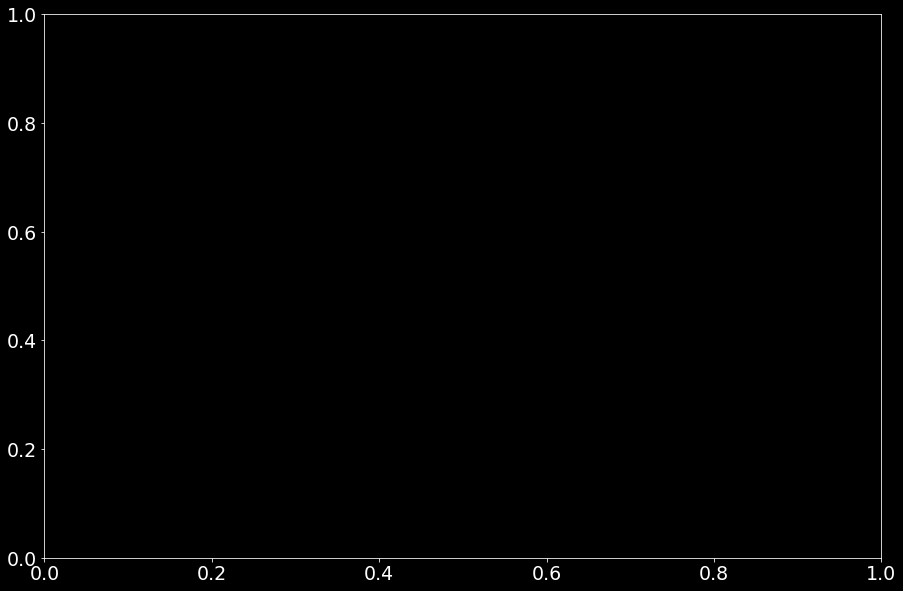

In [195]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 19})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (15, 10))
    plotted_model_metrics["Matrix (polarity)"] = plotted_model_metrics["matrix"] + " (" + plotted_model_metrics["polarity"] + ")"

    plotted_model_metrics.set_index(["Matrix (polarity)", "adduct_setup"], drop=True)[metric].unstack("adduct_setup").plot.bar(ax=ax)
    ax.legend(loc="lower left")
    ax.set_ylabel(metric)
    ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3)
    plt.tight_layout()
    fig.savefig(plots_dir / f"{selected_model}_{selected_train_setup}_adduct_setup_comparison.pdf")




### Plots for selecting pred_val_thresh

First, combine multiple csv in a single one:

In [196]:
foldernames_key = "val"
file_to_load = "results_all_feat.csv"
# model_metrics, model_metrics_global, models_predictions, model_typename = \
#         compute_scores(filenames, TASK_NAME, task_typename, EVAL_FEAT_SEL,
#                    test_all_adduct_setups=True)

In [197]:
all_results = pd.DataFrame()
for root, dirs, files in os.walk(results_dir, topdown=False):
    for dirname in dirs:
        if foldernames_key in dirname:
            # Deduce value of the threshold from the folder name:
            pred_val_thresh = eval("0." + dirname.split("_")[1][1:])
            loc_results = pd.read_csv(os.path.join(root, dirname, file_to_load), index_col=0)
            loc_results["pred_val_thresh"] = pred_val_thresh
            all_results = pd.concat([all_results, loc_results])
all_results.to_csv(results_dir / "thresh_results_combined.csv")

In [199]:
model_metrics, model_metrics_global, models_predictions, model_typename = compute_scores({"All features": "thresh_results_combined.csv"}, TASK_NAME, task_typename, EVAL_FEAT_SEL,
                   load_multiple_thresholds=True, thresh_column_name="pred_val_thresh")


In [202]:
model_metrics


,matrix,polarity,train_setup,model_type,adduct_setup,pred_val_thresh,not_det_precision,not_det_recall,not_det_f1,not_detected,det_precision,det_recall,det_f1,detected,macro_avg_f1_score
0,9AA,negative,All features,MLP,All adducts,0.05,0.571429,0.521739,0.545455,46,0.818182,0.846154,0.831933,117,0.688694
1,9AA,negative,All features,MLP,All adducts,0.10,0.550000,0.488889,0.517647,45,0.813008,0.847458,0.829876,118,0.673761
2,9AA,negative,All features,MLP,All adducts,0.20,0.521739,0.585366,0.551724,41,0.854701,0.819672,0.836820,122,0.694272
3,9AA,negative,All features,MLP,All adducts,0.30,0.648649,0.615385,0.631579,39,0.880952,0.895161,0.888000,124,0.759789
4,9AA,negative,All features,MLP,All adducts,0.40,0.621622,0.589744,0.605263,39,0.873016,0.887097,0.880000,124,0.742632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,pNA,positive,All features,MLP,All adducts,0.10,0.510204,0.531915,0.520833,47,0.808696,0.794872,0.801724,117,0.661279
128,pNA,positive,All features,MLP,All adducts,0.20,0.500000,0.500000,0.500000,40,0.840000,0.840000,0.840000,125,0.670000
129,pNA,positive,All features,MLP,All adducts,0.30,0.525000,0.538462,0.531646,39,0.856000,0.849206,0.852590,126,0.692118
130,pNA,positive,All features,MLP,All adducts,0.40,0.487179,0.513514,0.500000,37,0.857143,0.843750,0.850394,128,0.675197


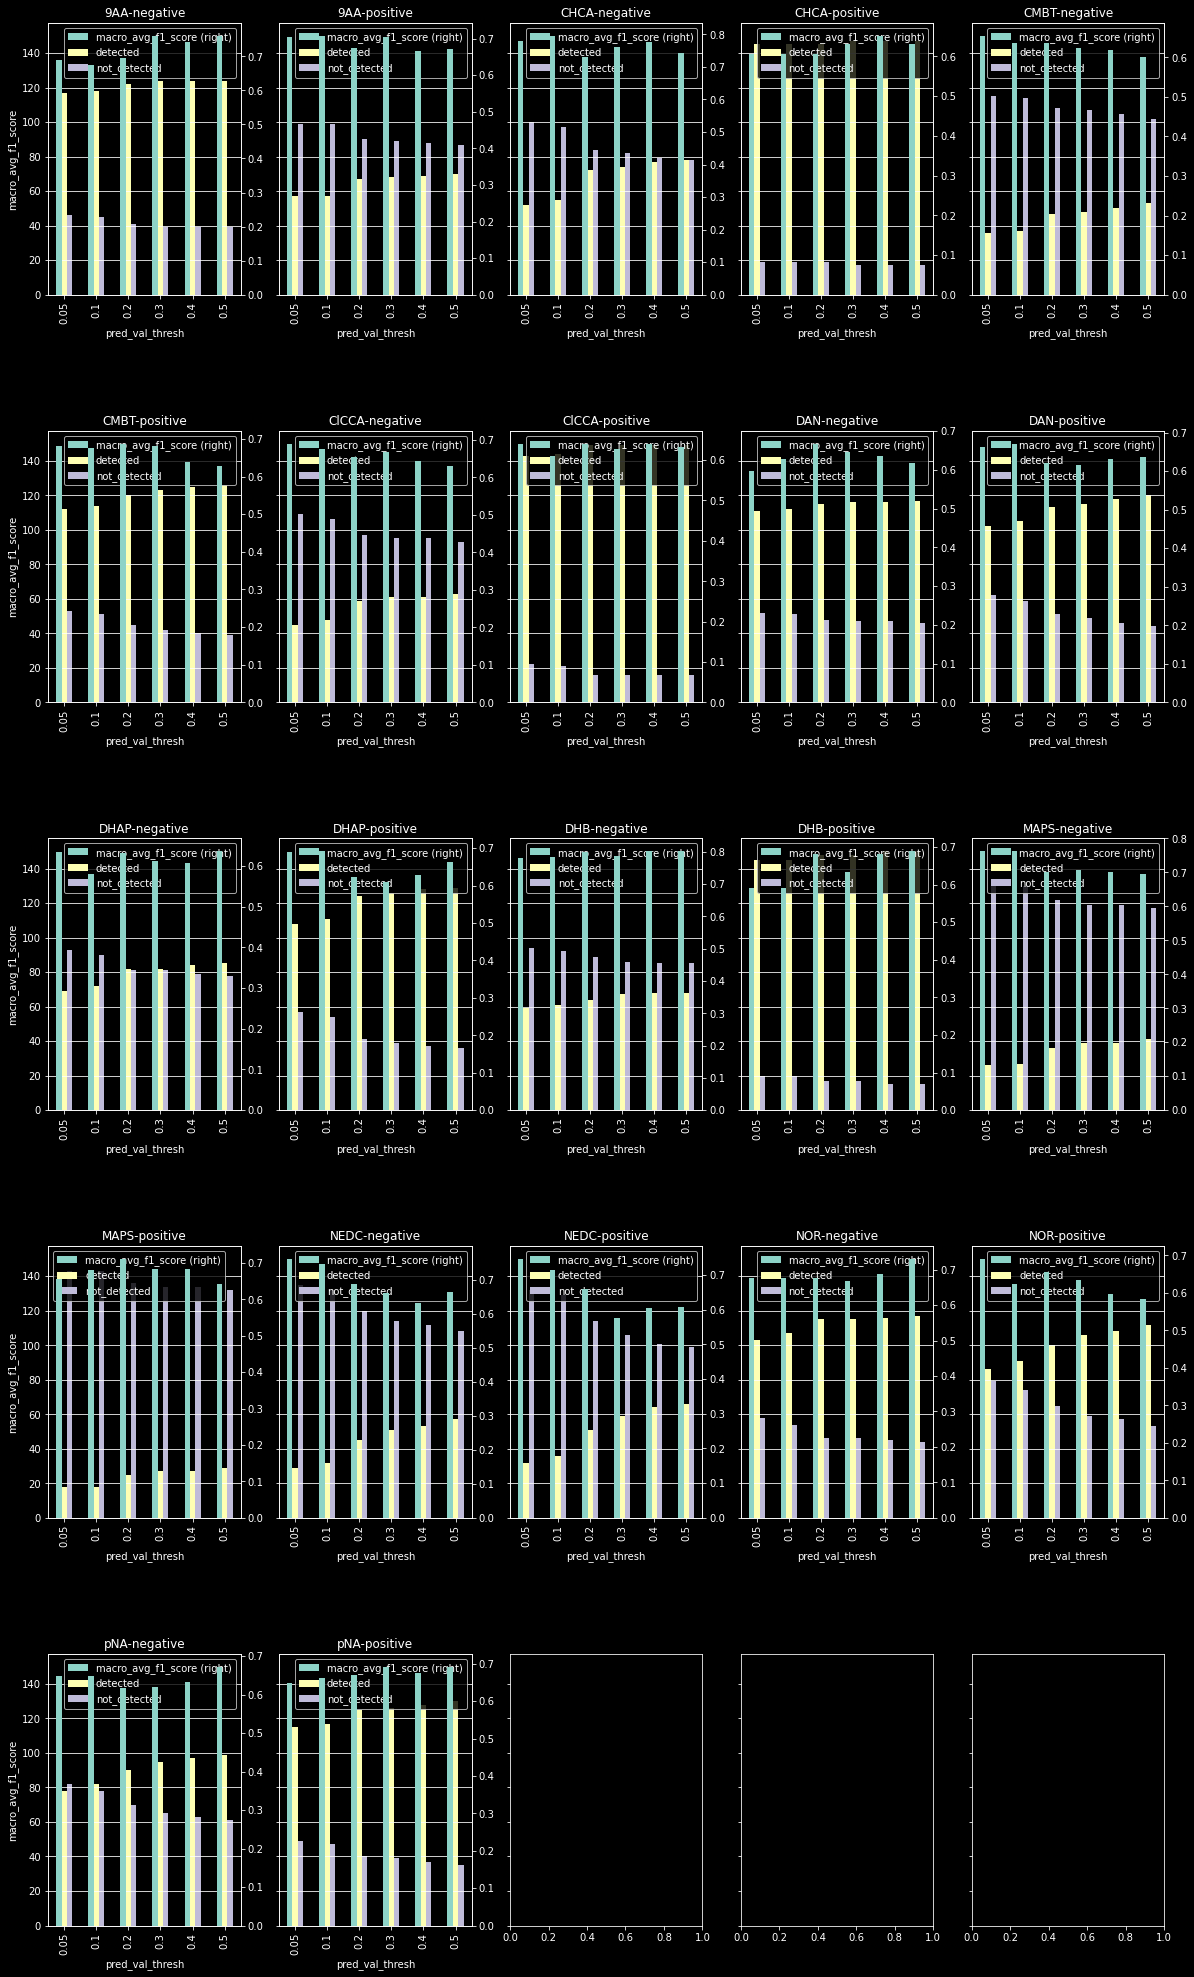

In [205]:
quantities_to_plot = {
    metric: metric,
    "non-zero obs": "Non-zero observations"
}
for q_to_plot in quantities_to_plot:
    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
    ax_list = axes.flat

    plotted_metrics = model_metrics
    i = 0
    for (matrix, polarity), rows in plotted_metrics.groupby(['matrix', 'polarity']):
        # nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
        # nb_obs = rows[count_key].drop_duplicates().values[0]
        # rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
        # rows["quantile (nb_feat)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
        rows = rows.set_index(["pred_val_thresh"], drop = True).sort_values( by = ["pred_val_thresh"])
        # rows = rows.unstack("feat_sel_method")
        # ax_twin = ax_list[i].twinx()
        # rows[[metric, "non-zero obs"]].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}",
        #                                         secondary_y="non-zero obs")
        rows[[metric, "detected", "not_detected"]].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}",
                                                secondary_y=metric)
        ax_list[i].set_ylabel(quantities_to_plot[q_to_plot])
        ax_list[i].grid(axis='y')
        # TODO: position legend
        # ax_list[i].legend(loc="lower right")
        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    (plots_dir / "pred_val_thresh").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "pred_val_thresh"/ f"{q_to_plot}.pdf")
    break


## Plot results for feature selection
If `EVAL_FEAT_SEL==False`, nothing will be plotted in this section

In [136]:
# feature_sel_method = "kendall"
feature_sel_method = "mean_abs_shap"

,matrix,polarity,train_setup,model_type,adduct_setup,feat_sel_method,quantile,nb_features,Spearman's R,S pval,Pearson's R,P pval,RMSE,RMSE/std,non-zero obs
0,9AA,negative,All features,MLP,All adducts,mean_abs_shap,0,365,0.671093,4.466782e-23,0.656081,8.464124e-22,1.020367,0.817227,166
1,9AA,negative,All features,MLP,All adducts,mean_abs_shap,1,303,0.697768,1.532359e-25,0.682569,4.186002e-24,0.966210,0.773852,166
2,9AA,negative,All features,MLP,All adducts,mean_abs_shap,2,241,0.675083,1.984885e-23,0.646887,4.729456e-21,1.038767,0.831965,166
3,9AA,negative,All features,MLP,All adducts,mean_abs_shap,3,179,0.668915,6.917070e-23,0.651590,1.976107e-21,1.020522,0.817351,166
4,9AA,negative,All features,MLP,All adducts,mean_abs_shap,4,117,0.674771,2.115895e-23,0.658316,5.520691e-22,0.998534,0.799741,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,2,241,0.766678,6.405755e-53,0.783092,1.355531e-56,0.599725,0.634430,267
458,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,3,179,0.746029,1.050905e-48,0.758248,3.789295e-51,0.636109,0.672920,267
459,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,4,117,0.658824,1.294874e-34,0.663669,2.843786e-35,0.739121,0.781893,267
460,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,5,55,0.516334,1.349566e-19,0.525371,2.396052e-20,0.862560,0.912476,267


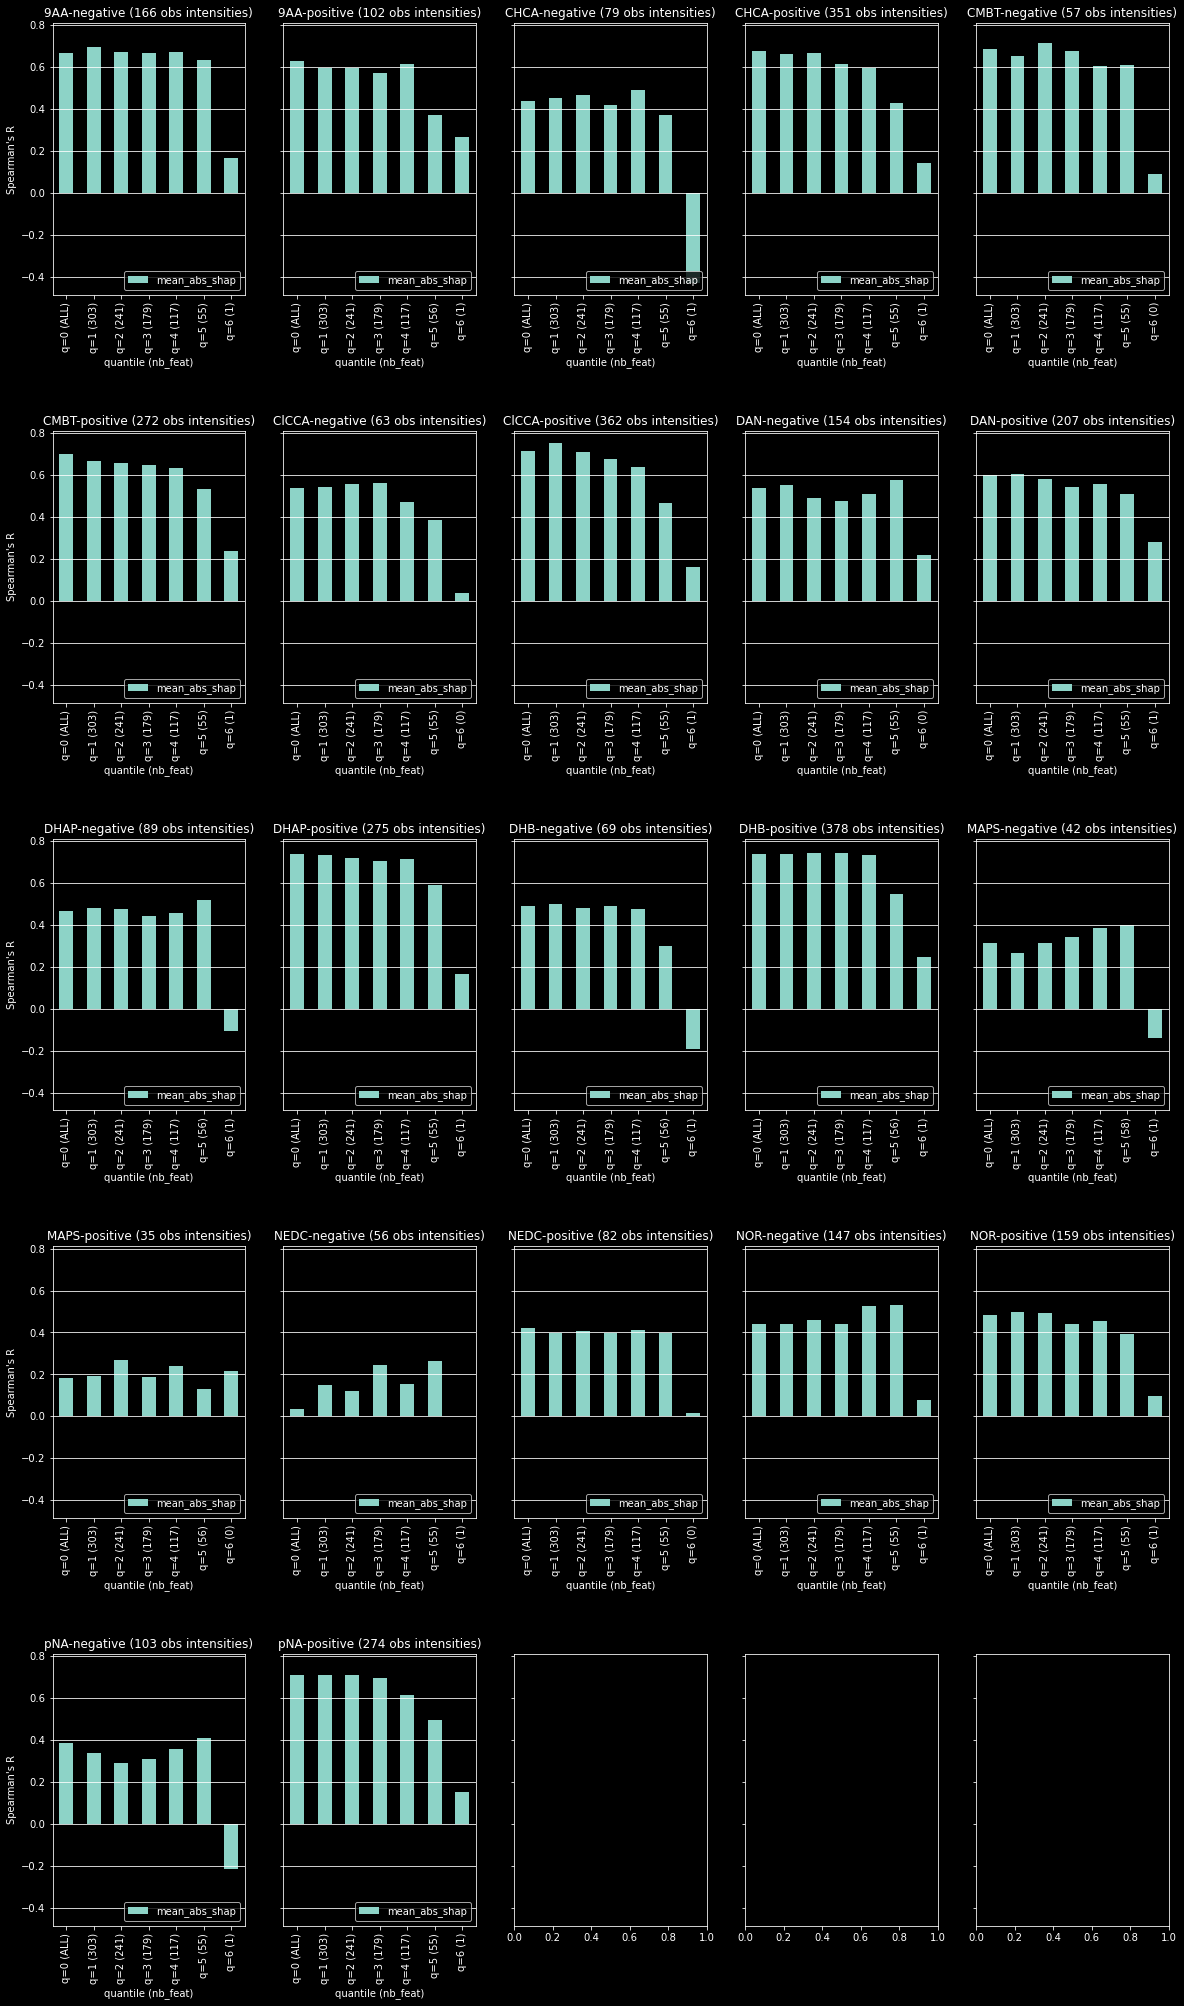

In [141]:
if EVAL_FEAT_SEL:

    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
    ax_list = axes.flat

    plotted_metrics = model_metrics[model_metrics.feat_sel_method == feature_sel_method]
    i = 0
    for (matrix, polarity), rows in plotted_metrics.groupby(['matrix', 'polarity']):
        # nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
        nb_obs = rows[count_key].drop_duplicates().values[0]
        rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
        rows["quantile (nb_feat)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
        rows = rows.set_index(["quantile (nb_feat)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
        rows = rows.unstack("feat_sel_method")
        rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs} obs intensities)")
        ax_list[i].set_ylabel(metric)
        ax_list[i].grid(axis='y')
        # TODO: position legend
        ax_list[i].legend(loc="lower right")
        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    (plots_dir / "feat_selection").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}.pdf")


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_79595/3160736158.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_79595/3160736158.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"


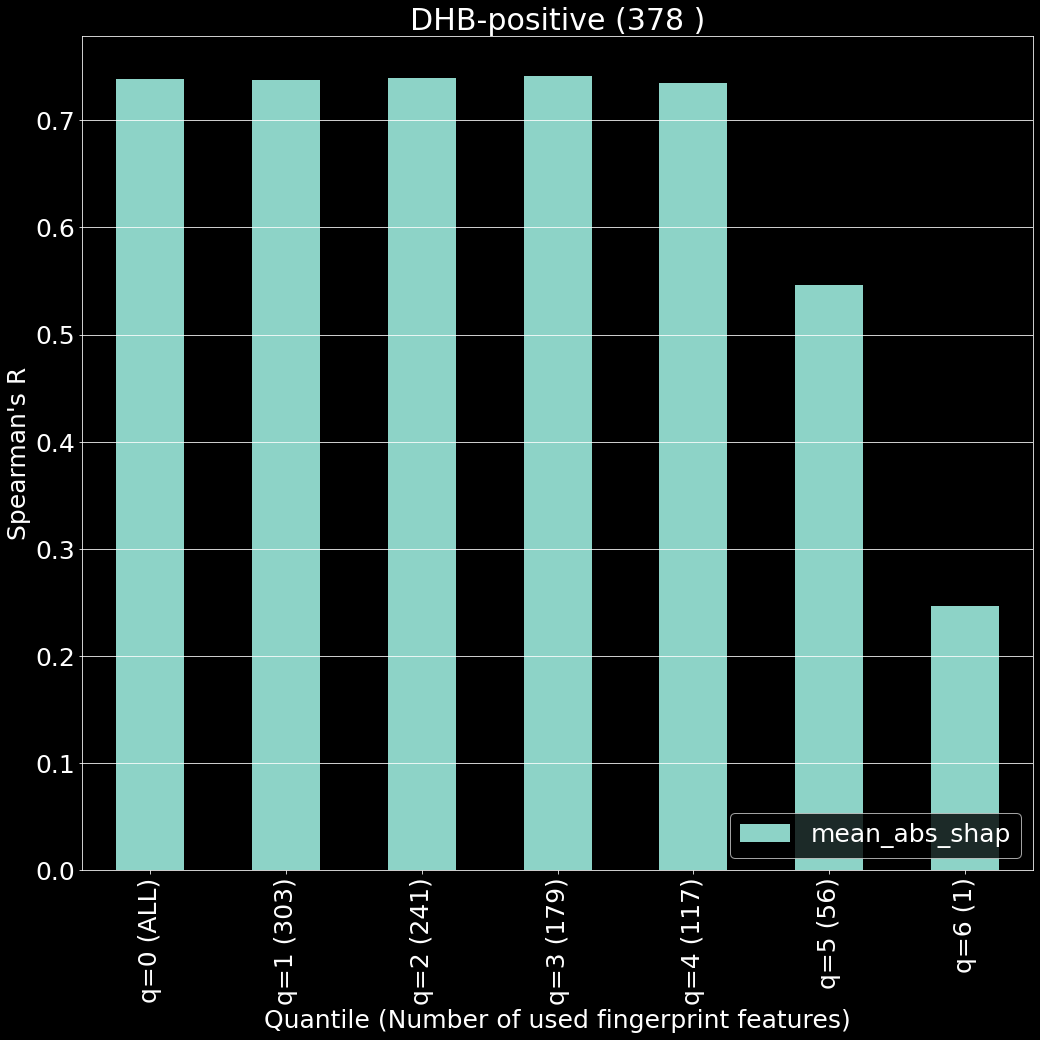

In [142]:
if EVAL_FEAT_SEL:
    plt.rcParams.update({'font.size': 25})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (15, 15))


    rows = model_metrics[(model_metrics.feat_sel_method == feature_sel_method) &
                                    (model_metrics.matrix == "DHB") & (model_metrics.polarity == "positive")]
    if "detection" in TASK_NAME:
        count_key = 'detected'
    elif "regression" in TASK_NAME:
        count_key = 'non-zero obs'
    nb_obs = rows[count_key].drop_duplicates().values[0]
    rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
    rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
    rows = rows.set_index(["Quantile (Number of used fingerprint features)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
    rows = rows.unstack("feat_sel_method")
    rows[metric].plot.bar(ax = ax, title=f"DHB-positive ({nb_obs} )")
    ax.set_ylabel(metric)
    ax.grid(axis='y')
    # TODO: position legend
    ax.legend(loc="lower right")
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)

    # plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()
    (plots_dir / "feat_selection").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}-DHB-positive.pdf")

In [82]:
if EVAL_FEAT_SEL:
    model_metrics_global.set_index(['quantile', "feat_sel_method"], drop=True)[metric].unstack("feat_sel_method").plot.bar(figsize=(10,10))